# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

In [452]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request
from scipy import stats as sc_stats 
from collections import namedtuple, defaultdict

%matplotlib inline

In [453]:
get_qap_instance_url = lambda n: f'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug{n}.dat'

In [473]:
Opt = namedtuple('Opt', ['val', 'perm'])

opts = {
   12: Opt(578, (12,7,9,3,4,8,11,1,5,6,10,2)),
   14: Opt(1014, (9,8,13,2,1,11,7,14,3,4,12,5,6,10)),
   15: Opt(1150, (1,2,13,8,9,4,3,14,7,11,10,15,6,5,12)),
   16: Opt(1610, (9,14,2,15,16,3,10,12,8,11,6,5,7,1,4,13)),
#   16b: Opt(1240, (16,12,13,8,4,2,9,11,15,10,7,3,14,6,1,5)),
   17: Opt(1732, (16,15,2,14,9,11,8,12,10,3,4,1,7,6,13,17,5)),
   18: Opt(1930, (10,3,14,2,18,6,7,12,15,4,5,1,11,8,17,13,9,16)),
   20: Opt(2570, (18,14,10,3,9,4,2,12,11,16,19,15,20,8,13,17,5,7,1,6)),
   21: Opt(2438, (4,21,3,9,13,2,5,14,18,11,16,10,6,15,20,19,8,7,1,12,17)),
   22: Opt(3596, (2,21,9,10,7,3,1,19,8,20,17,5,13,6,12,16,11,22,18,14,15)),
   24: Opt(3488, (17,8,11,23,4,20,15,19,22,18,3,14,1,10,7,9,16,21,24,12,6,13,5,2)),
   25: Opt(3744, (5,11,20,15,22,2,25,8,9,1,18,16,3,6,19,24,21,14,7,10,17,12,4,23,13)),
   27: Opt(5234, (23,18,3,1,27,17,5,12,7,15,4,26,8,19,20,2,24,21,14,10,9,13,22,25,6,16,11)),
   28: Opt(5166, (18,21,9,1,28,20,11,3,13,12,10,19,14,22,15,2,25,16,4,23,7,17,24,26,5,27,8,6)),
   30: Opt(6124, (5, 12, 6, 13, 2, 21, 26, 24, 10, 9, 29, 28, 17, 1, 8, 7, 19, 25, 23, 22, 11, 16, 30, 4, 15, 18, 27, 3, 14, 20,)),
}

## Reading input data

In [455]:
nug_instance = 12


def get_qap_data(nug_instance):
    qap_instance_file = urllib.request.urlopen(get_qap_instance_url(nug_instance))
    
    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Flow matrix:\n', A)

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Distance matrix:\n', B)
    return A, B

flow, distance = get_qap_data(nug_instance)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

## Objective function

In [456]:
def qap_objective_function(perm, nug_instance, flow, distance):
    s = 0.0
    for i in range(nug_instance):
        s += (flow[i, :] * distance[perm[i], perm]).sum()
    return s

In [457]:
perm = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]

print(qap_objective_function(perm, nug_instance, flow, distance), perm)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [458]:
t0 = time.time()

T = 100000

n = nug_instance

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    if not (i % (T/10)):
        print('.', end='')
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :], n, flow, distance)

print(f'\nexec time: {time.time() - t0}')

perm = permutations[costs.argmin(), :]
print(qap_objective_function(perm, n, flow, distance), perm)

..........
exec time: 8.131369590759277
614.0 [11  8 10  9  3  7  6  5  0  2  1  4]


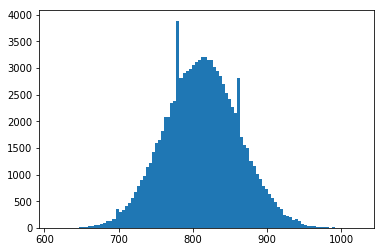

812.02644 49.6713480884745


In [459]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [460]:
def random_neighbor(perm, radius):
    q = perm.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)  # pick two diff. numbers from [0, 11]
        q[i], q[j] = q[j], q[i]
    return q

In [506]:
# S = permutations similarity index

def simulated_annealing(T, radius, alpha, n, flow, distance, S=-1):
    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = qap_objective_function(p, n, flow, distance)
    costs = np.zeros(T)
    successes = np.zeros(T)
    random_choices = np.zeros(T)
    perms_diff = np.zeros((T, 2), dtype=np.float64)
    perms = np.empty((T, n), dtype=np.int64)

    for t in range(T):
        if not t % (T/10):
            print('.', end='')
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q, n, flow, distance)
        
        similarity_cond = lambda: S != -1 and (np.random.rand() < np.exp(- S * t * (1-perms_distance(p, q))*1000))
        annealing_cond = lambda: np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)

        if(q_cost < p_cost):
            successes[t] += 1
            perms_diff[t] = (p_cost - q_cost, perms_distance(p, q))
            p, p_cost = q, q_cost
        elif similarity_cond() or annealing_cond():
            random_choices[t] += 1
            p, p_cost = q, q_cost
        costs[t] = p_cost
        perms[t, :] = p

    print(f'\nexec time: {time.time() - t0}')
    return {
        'costs': costs,
        'perms': perms,
        'successes': successes,
        'random_choices': random_choices,
        'perms_diff': perms_diff,
    }

def perms_distance(p1, p2):
    """Calculate Kendall tau distance"""
    tau, p_value = sc_stats.kendalltau(p1, p2)
    return tau

def relative_error(x, x0):
    return np.abs(x - x0) / x

def absolute_error(x, x0):
    return np.abs(x - x0)

def plot_results(n, T, **data):
    figsize = (12, 4)
    costs = data['costs']
    perms = data['perms']
    successes = data['successes']
    random_choices = data['random_choices']
    perms_diff = data['perms_diff']

    print(f'min cost: {costs.min()}')
    print(f'opt cost: {opts[n].val}')
    print(f'perm: {tuple(perms[costs.argmin(), :])}')
    print(f'optp: {opts[n].perm}')
    print(f'\nOPT: {opts[n]}')
    print(f'Relative error: {relative_error(opts[n].val, costs.min())}')
    print(f'Absolute error: {absolute_error(opts[n].val, costs.min())}')
    print(f'costs mean: {costs.mean()}')
    print(f'costs std: {costs.std()}')

    plt.figure(figsize=figsize, dpi=80)
    plt.title('Results')
    plt.plot(costs)

    def plot_range(vals, title):
        xs = []
        ys = []
        sum = 0
        for i, val in enumerate(vals):
            sum += val
            if not i % (T/1000):
                xs.append(i)
                ys.append(sum)
                sum = 0
        
        plt.figure(figsize=figsize, dpi=80)
        plt.title(title)
        plt.plot(xs, ys)

    perms_xs, perms_ys = list(zip(*perms_diff))

    plt.figure(figsize=figsize, dpi=80)
    plt.title('Permutations difference and costs')
    plt.plot(perms_xs, perms_ys, 'ro')

    plot_range(successes, "Successes rate")
    plot_range(random_choices, "Random choices rate")

    plt.figure(figsize=figsize, dpi=80)
    plt.title('Histogram')
    plt.hist(costs, bins=30)
    plt.show()


In [498]:
# Define problem size
nug_instance = 12

flow, distance = get_qap_data(nug_instance)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

..........
exec time: 35.77326035499573
min cost: 578.0
opt cost: 578
perm: (2, 8, 6, 11, 0, 10, 7, 3, 1, 9, 5, 4)
optp: (12, 7, 9, 3, 4, 8, 11, 1, 5, 6, 10, 2)

OPT: Opt(val=578, perm=(12, 7, 9, 3, 4, 8, 11, 1, 5, 6, 10, 2))
Relative error: 0.0
Absolute error: 0.0
costs mean: 594.84058
costs std: 46.247845628349


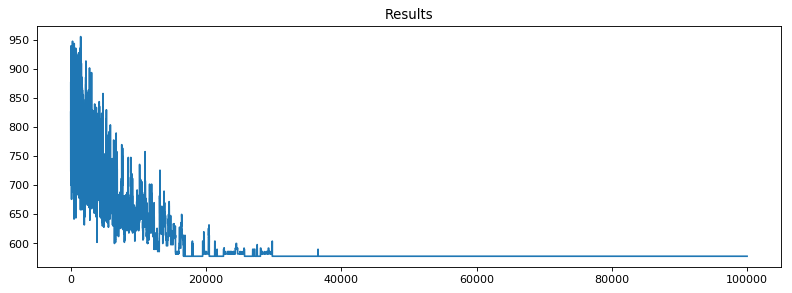

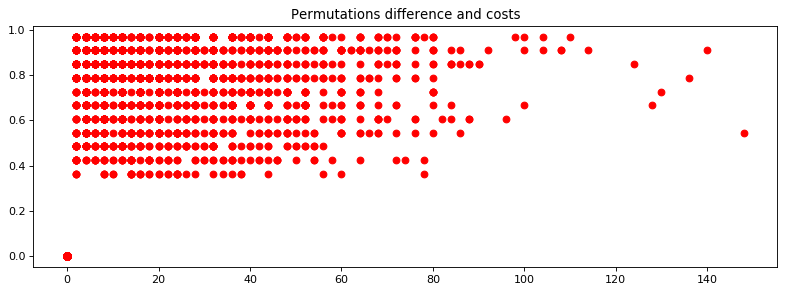

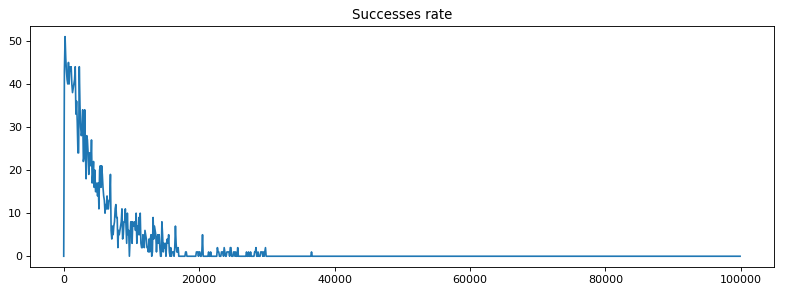

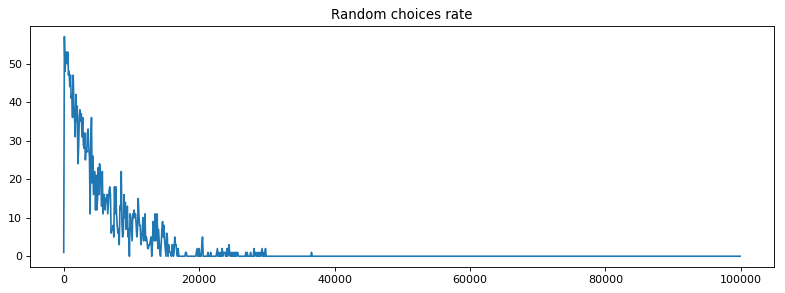

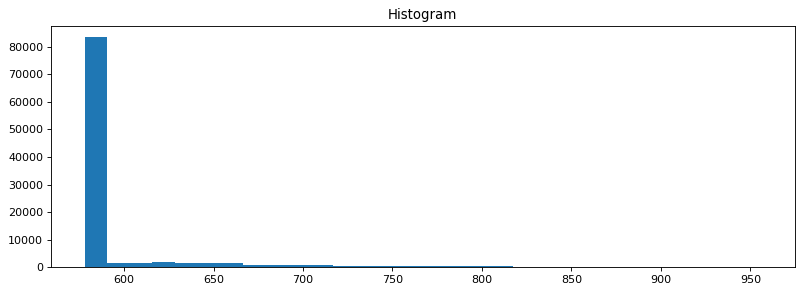

In [499]:
# Solution for problem size = 12

T = 100000
radius = 1
alpha = 1.0

results = simulated_annealing(T, radius, alpha, nug_instance, flow, distance)
plot_results(nug_instance, T, **results)


..........
exec time: 20.411426305770874
min cost: 586.0
opt cost: 578
perm: (4, 3, 7, 11, 5, 10, 6, 8, 9, 1, 0, 2)
optp: (12, 7, 9, 3, 4, 8, 11, 1, 5, 6, 10, 2)

OPT: Opt(val=578, perm=(12, 7, 9, 3, 4, 8, 11, 1, 5, 6, 10, 2))
Relative error: 0.01384083044982699
Absolute error: 8.0
costs mean: 710.60252
costs std: 65.30799223410256


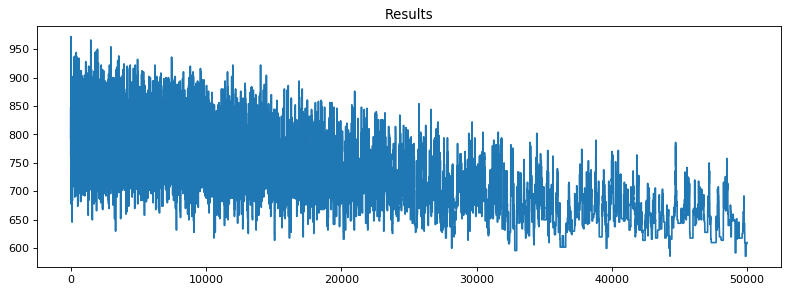

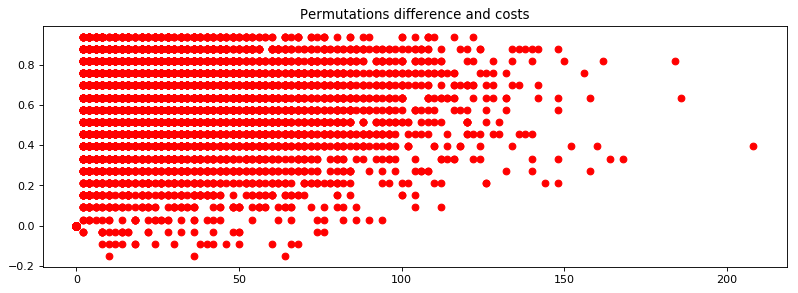

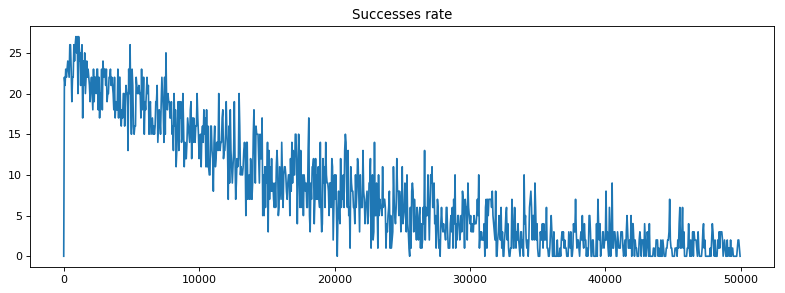

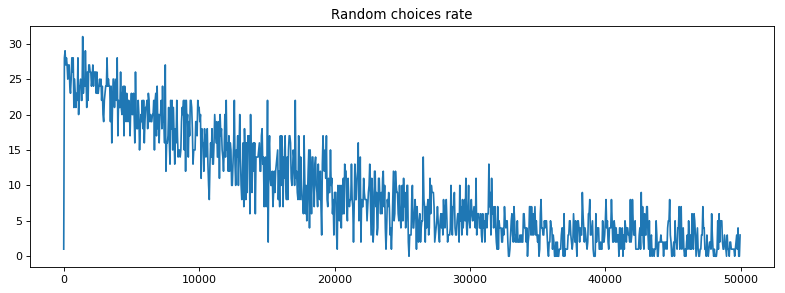

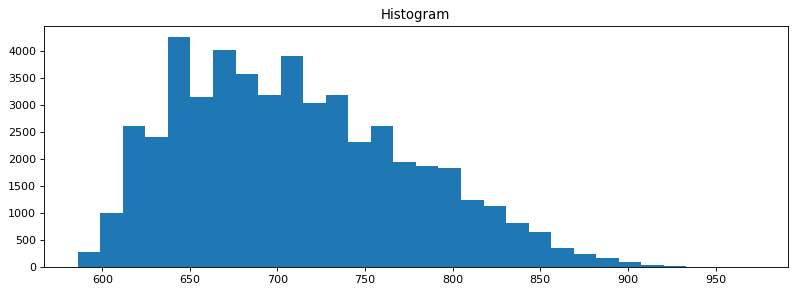

In [500]:
# Visualization with low alpha for problem size = 12

T = 50000
radius = 2
alpha = 0.1

results = simulated_annealing(T, radius, alpha, nug_instance, flow, distance)
plot_results(nug_instance, T, **results)


In [519]:
nug_instance = 14

flow, distance = get_qap_data(nug_instance)

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

..........
exec time: 41.83166432380676
min cost: 1054.0
opt cost: 1014
perm: (1, 13, 3, 4, 5, 0, 12, 2, 6, 9, 10, 8, 7, 11)
optp: (9, 8, 13, 2, 1, 11, 7, 14, 3, 4, 12, 5, 6, 10)

OPT: Opt(val=1014, perm=(9, 8, 13, 2, 1, 11, 7, 14, 3, 4, 12, 5, 6, 10))
Relative error: 0.03944773175542406
Absolute error: 40.0
costs mean: 1073.7743333333333
costs std: 55.71589510982381


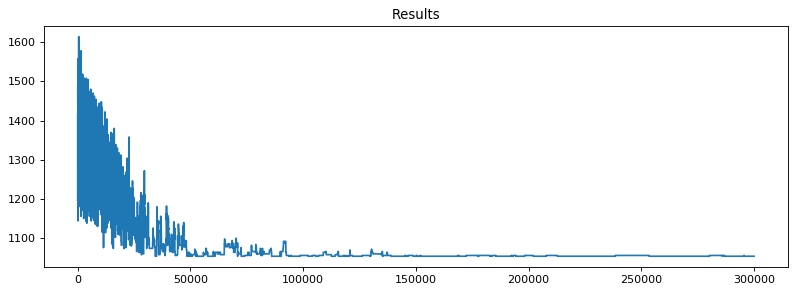

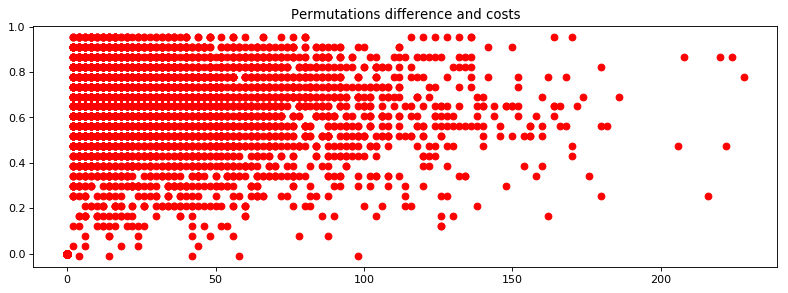

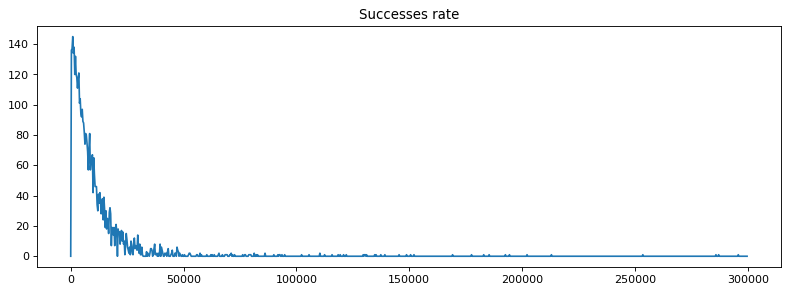

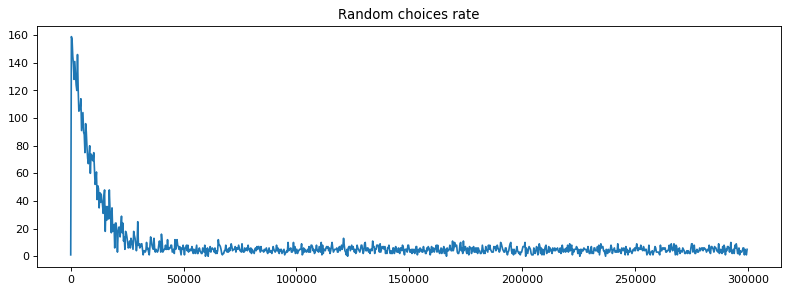

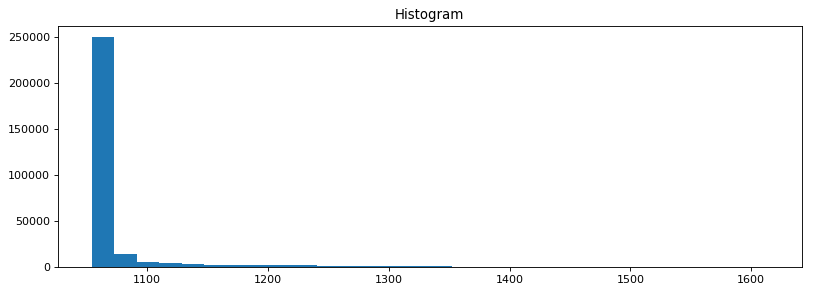

In [520]:
# Solution for problem size = 14

T = 300000
radius = 2
alpha = 0.9

results = simulated_annealing(T, radius, alpha, nug_instance, flow, distance)
plot_results(nug_instance, T, **results)


In [510]:
# Define problem size
nug_instance = 15

flow, distance = get_qap_data(nug_instance)

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

..........
exec time: 55.8327419757843
min cost: 1254.0
opt cost: 1150
perm: (5, 13, 14, 4, 11, 1, 12, 6, 7, 8, 0, 3, 9, 2, 10)
optp: (1, 2, 13, 8, 9, 4, 3, 14, 7, 11, 10, 15, 6, 5, 12)

OPT: Opt(val=1150, perm=(1, 2, 13, 8, 9, 4, 3, 14, 7, 11, 10, 15, 6, 5, 12))
Relative error: 0.09043478260869565
Absolute error: 104.0
costs mean: 1263.3769733333334
costs std: 38.7491215957122


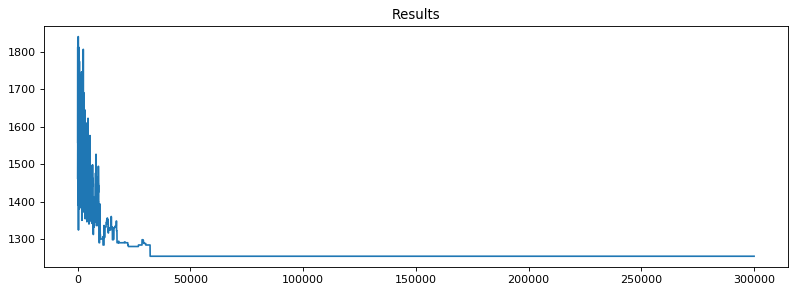

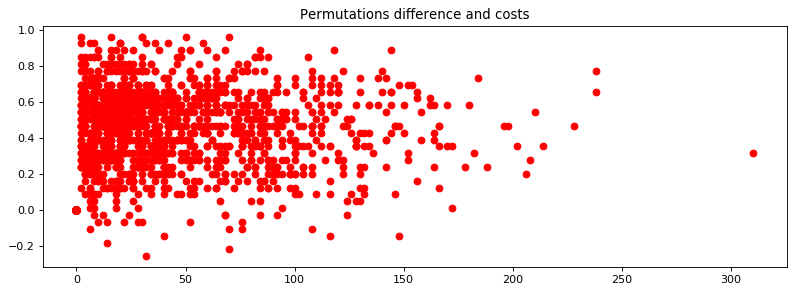

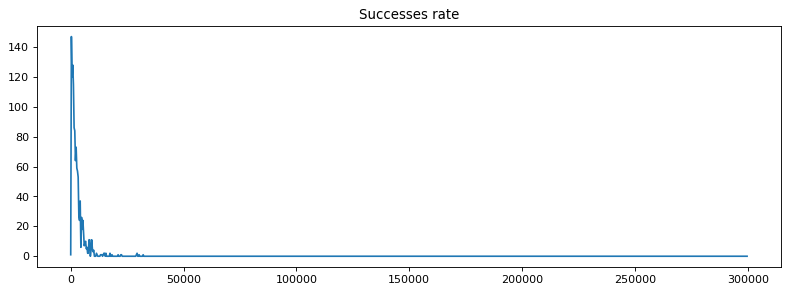

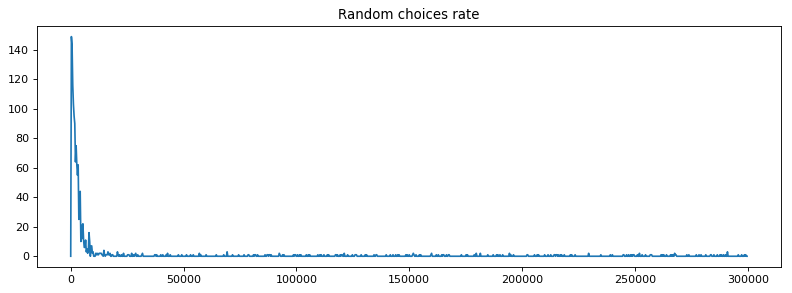

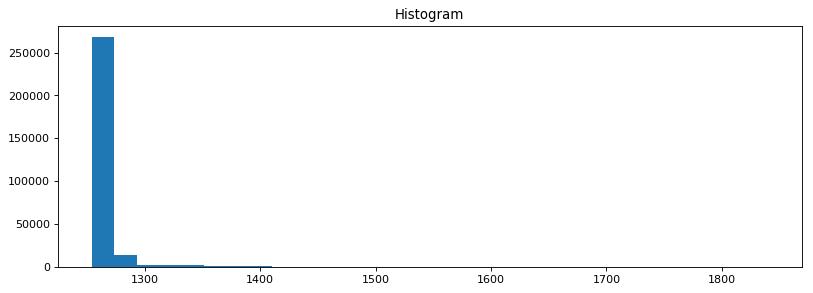

In [511]:
# Solution for problem size = 15

# T = 100000
# radius = 3
# alpha = 1.7

T = 300000
radius = 4
alpha = 2.5

results = simulated_annealing(T, radius, alpha, nug_instance, flow, distance)
plot_results(nug_instance, T, **results)

In [512]:
# Define problem size
nug_instance = 17

flow, distance = get_qap_data(nug_instance)

Problem size: 17
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4.]
 [3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1.]
 [4. 3. 4. 5. 6. 3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0.]]
Distance matrix:
 [[ 0.  0.  5.  0.  5.  2. 10.  3

..........
exec time: 17.875823974609375
min cost: 1896.0
opt cost: 1732
perm: (5, 12, 6, 3, 16, 2, 15, 0, 10, 14, 9, 13, 11, 1, 7, 8, 4)
optp: (16, 15, 2, 14, 9, 11, 8, 12, 10, 3, 4, 1, 7, 6, 13, 17, 5)

OPT: Opt(val=1732, perm=(16, 15, 2, 14, 9, 11, 8, 12, 10, 3, 4, 1, 7, 6, 13, 17, 5))
Relative error: 0.09468822170900693
Absolute error: 164.0
costs mean: 1910.57548
costs std: 48.93307779784141


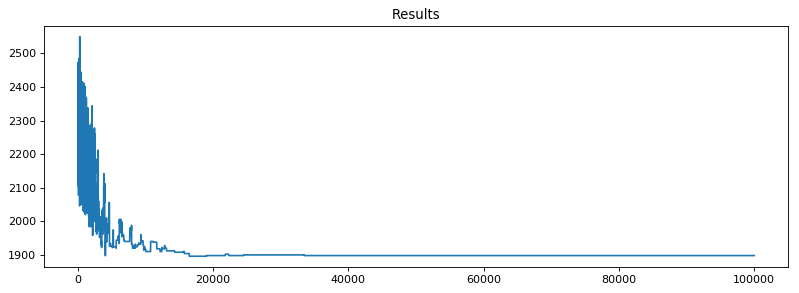

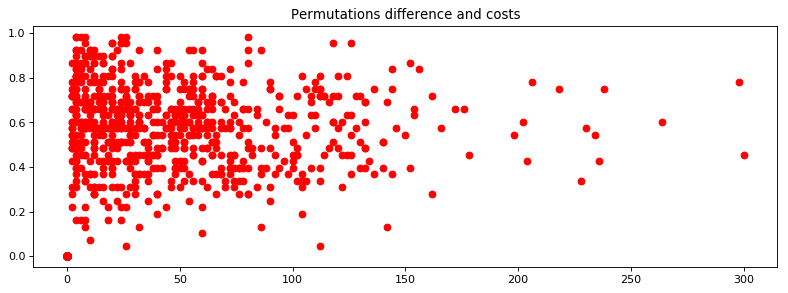

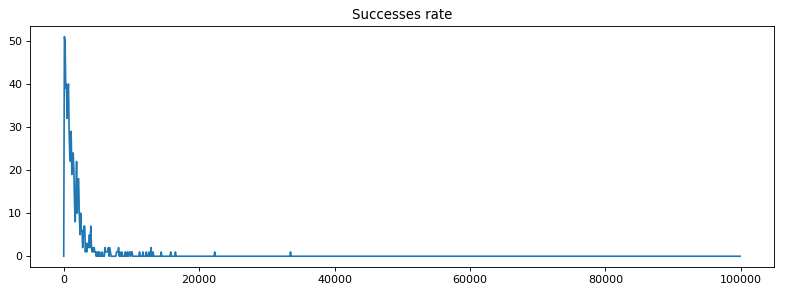

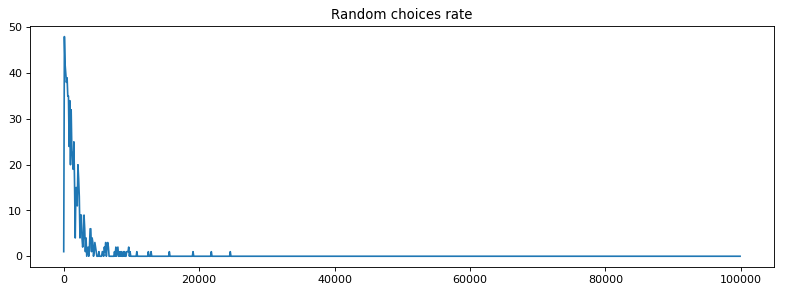

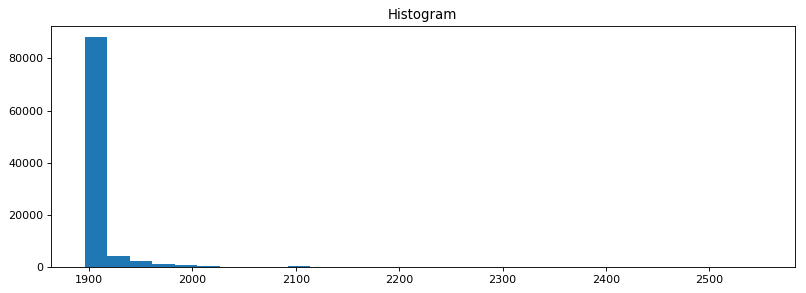

In [513]:
# Solution for problem size = 17

# T = 100000
# radius = 2
# alpha = 0.4
#
# radius = 2
# alpha = 0.9

T = 100000
radius = 3
alpha = 1.4

results = simulated_annealing(T, radius, alpha, nug_instance, flow, distance)
plot_results(nug_instance, T, **results)

In [514]:
# Define problem size
nug_instance = 20

flow, distance = get_qap_data(nug_instance)

Problem size: 20
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4. 5. 6. 7.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5. 6.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5. 4. 3. 4.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [3. 4. 5. 6. 7. 2. 3. 4

..........
exec time: 64.56832456588745
min cost: 2902.0
opt cost: 2570
perm: (15, 0, 4, 8, 16, 10, 11, 6, 13, 2, 19, 14, 1, 3, 17, 7, 9, 5, 18, 12)
optp: (18, 14, 10, 3, 9, 4, 2, 12, 11, 16, 19, 15, 20, 8, 13, 17, 5, 7, 1, 6)

OPT: Opt(val=2570, perm=(18, 14, 10, 3, 9, 4, 2, 12, 11, 16, 19, 15, 20, 8, 13, 17, 5, 7, 1, 6))
Relative error: 0.12918287937743192
Absolute error: 332.0
costs mean: 2918.8315866666667
costs std: 62.144828776140535


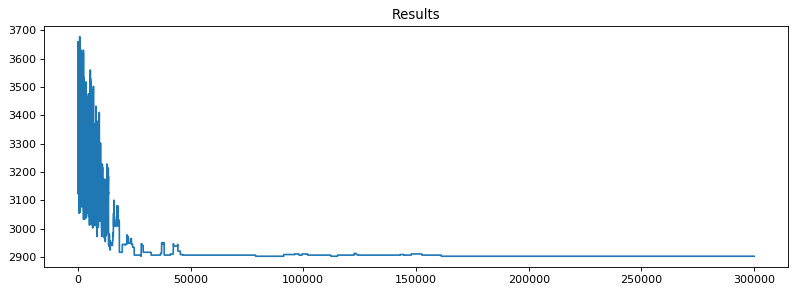

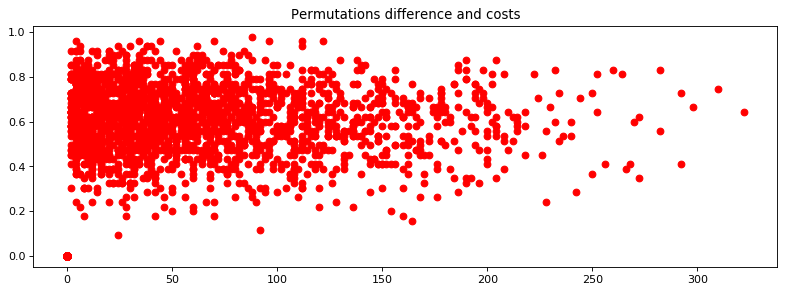

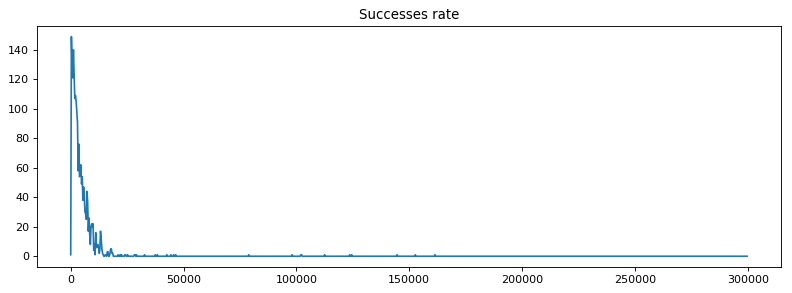

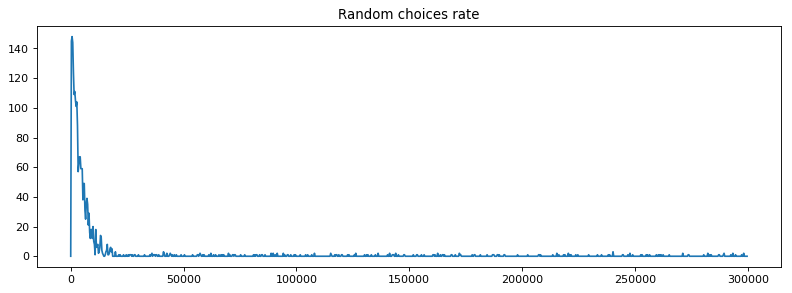

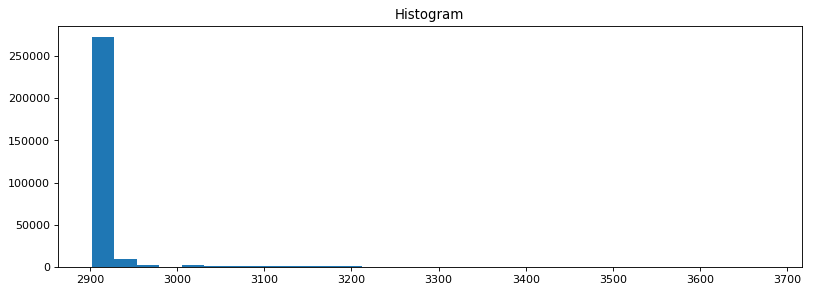

In [515]:
# Solution for problem size = 20

T = 300000
radius = 3
alpha = 1.1

results = simulated_annealing(T, radius, alpha, nug_instance, flow, distance)
plot_results(nug_instance, T, **results)

..........
exec time: 60.75581336021423
min cost: 3038.0
opt cost: 2570
perm: (16, 17, 9, 5, 2, 3, 10, 0, 11, 8, 18, 19, 4, 1, 13, 14, 7, 15, 12, 6)
optp: (18, 14, 10, 3, 9, 4, 2, 12, 11, 16, 19, 15, 20, 8, 13, 17, 5, 7, 1, 6)

OPT: Opt(val=2570, perm=(18, 14, 10, 3, 9, 4, 2, 12, 11, 16, 19, 15, 20, 8, 13, 17, 5, 7, 1, 6))
Relative error: 0.1821011673151751
Absolute error: 468.0
costs mean: 3060.0879266666666
costs std: 68.73293777780744


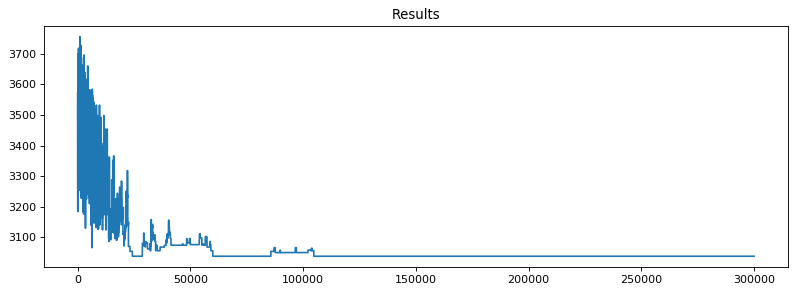

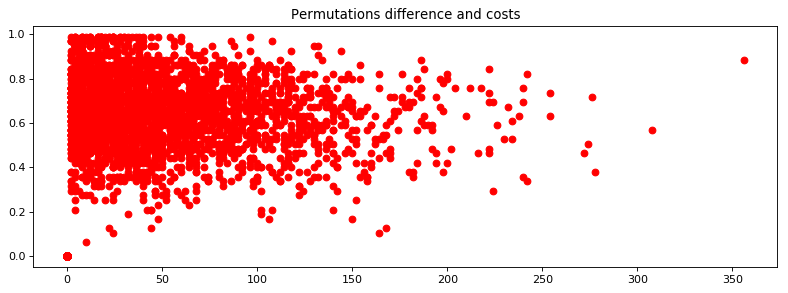

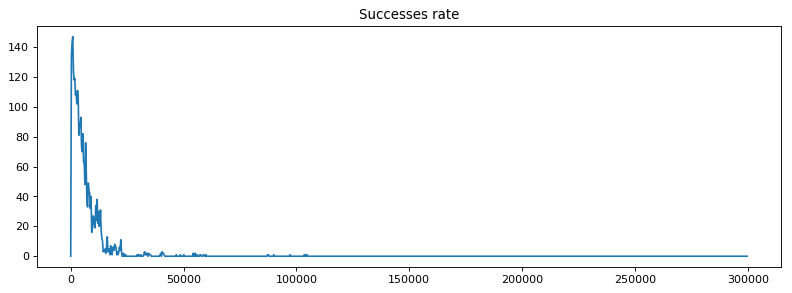

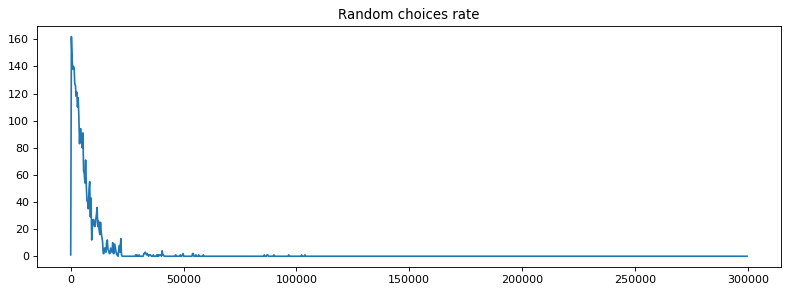

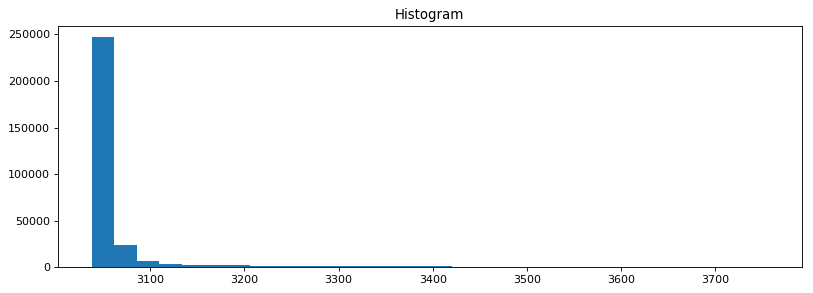

In [517]:
# Solution for problem size = 20

T = 300000
radius = 3
alpha = 0.95

results = simulated_annealing(T, radius, alpha, nug_instance, flow, distance)
plot_results(nug_instance, T, **results)

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

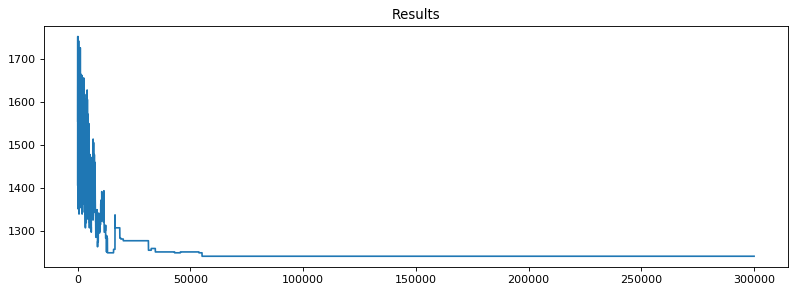

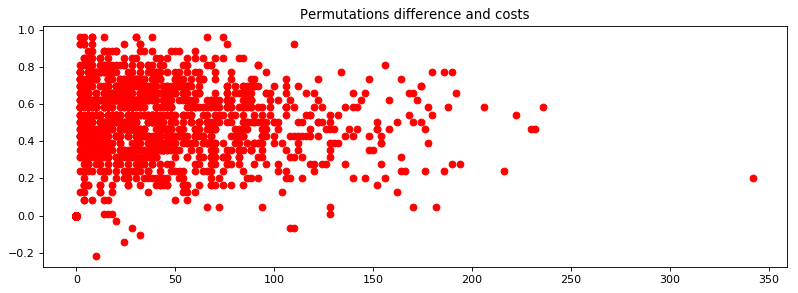

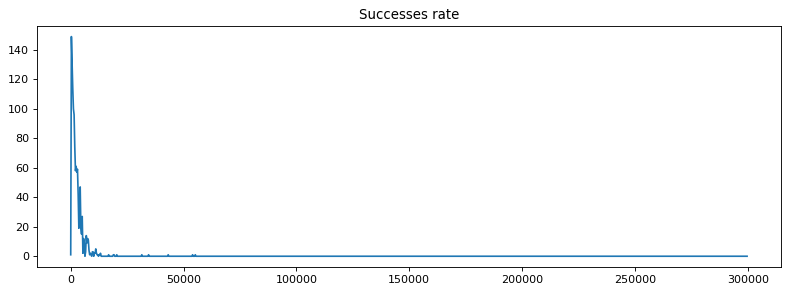

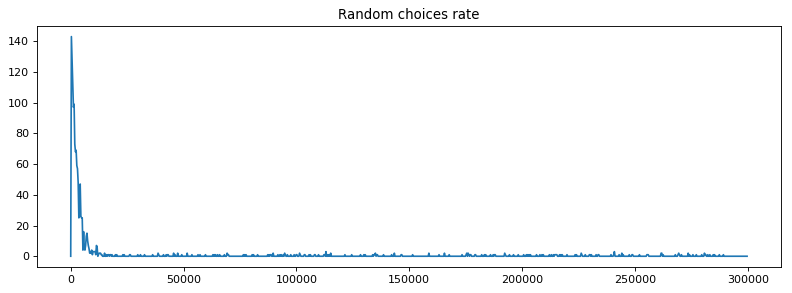

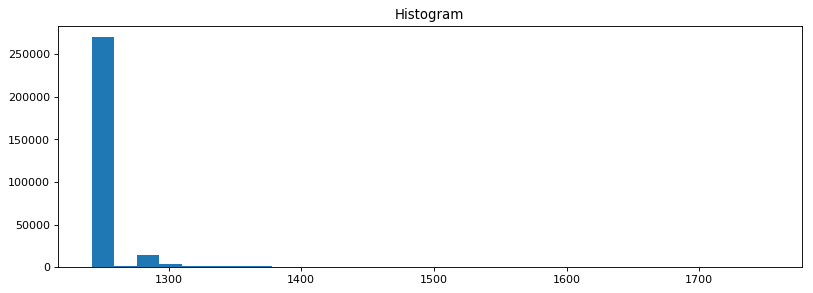

In [521]:
# Solution for problem size = 15 with S=10

nug_instance = 15

flow, distance = get_qap_data(nug_instance)

# T = 100000
# radius = 3
# alpha = 1.7

T = 300000
radius = 4
alpha = 2.5
S = 10

results = simulated_annealing(T, radius, alpha, nug_instance, flow, distance, S)
plot_results(nug_instance, T, **results)

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

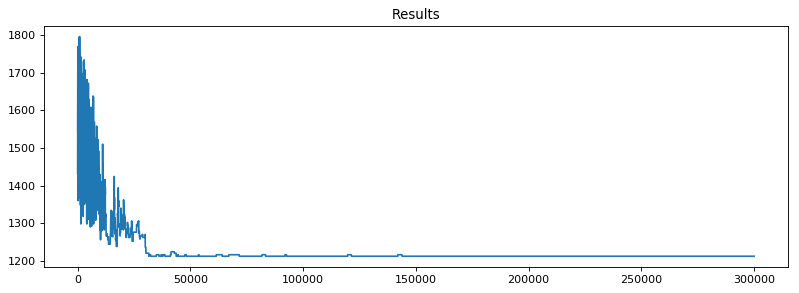

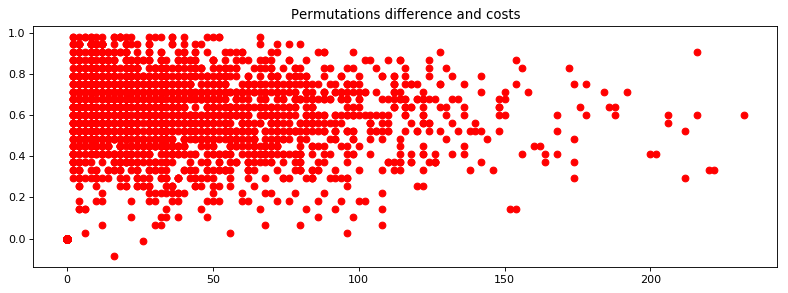

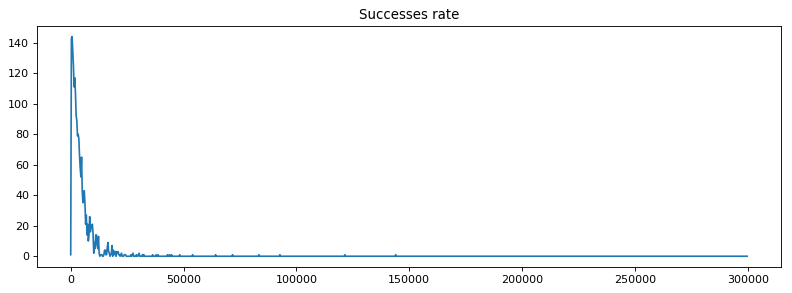

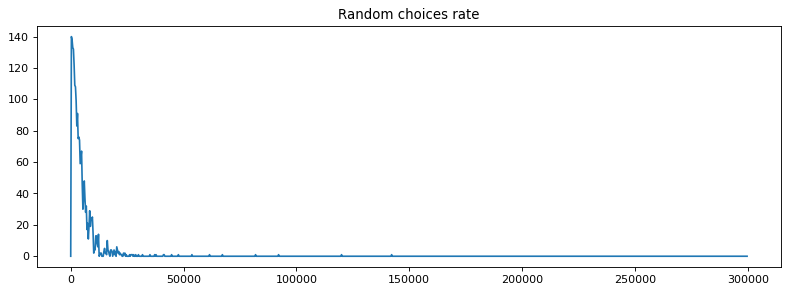

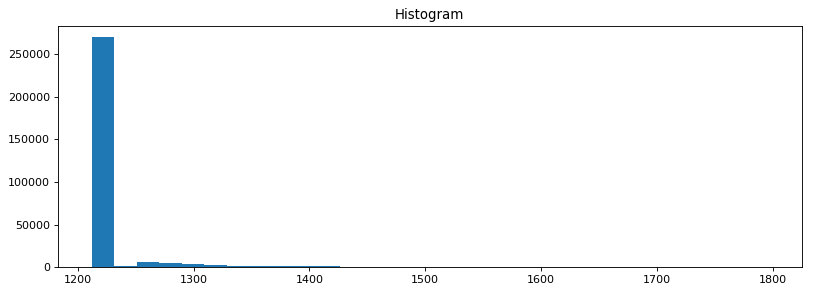

In [522]:
# Solution for problem size = 15 with S=1

nug_instance = 15

flow, distance = get_qap_data(nug_instance)

T = 300000
radius = 3
alpha = 1.7
S = 1

results = simulated_annealing(T, radius, alpha, nug_instance, flow, distance, S)
plot_results(nug_instance, T, **results)

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

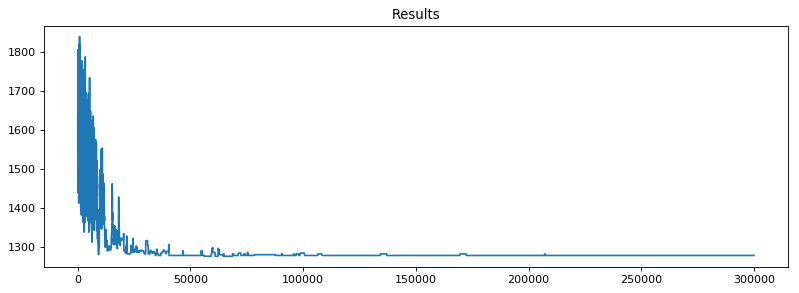

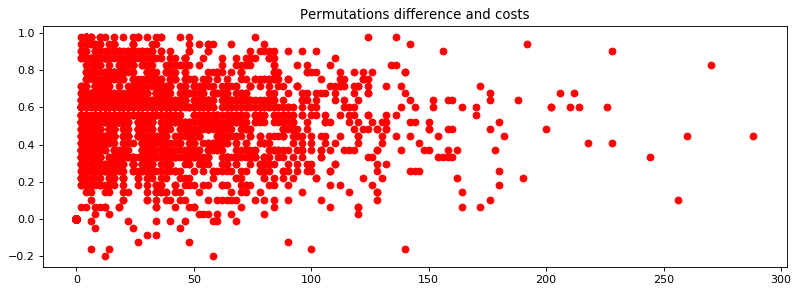

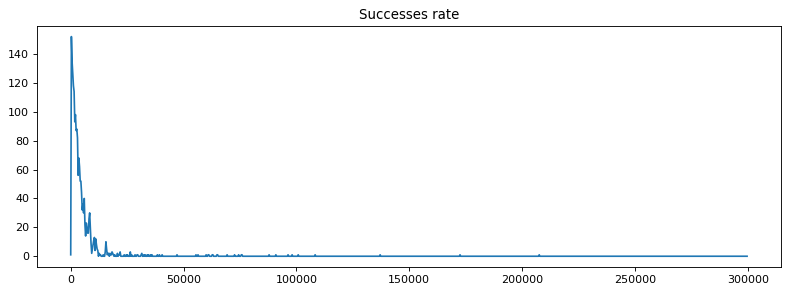

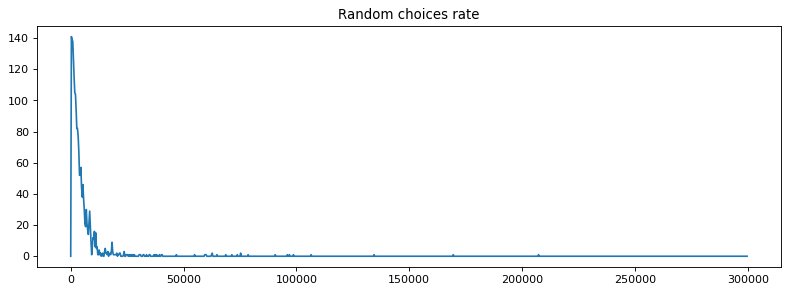

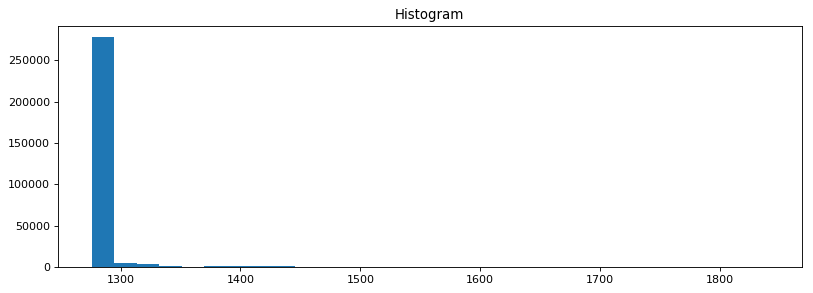

In [523]:
# Solution for problem size = 15 without S

nug_instance = 15

flow, distance = get_qap_data(nug_instance)

T = 300000
radius = 3
alpha = 1.7

results = simulated_annealing(T, radius, alpha, nug_instance, flow, distance, S)
plot_results(nug_instance, T, **results)

..........
exec time: 138.12575721740723
min cost: 1186.0
opt cost: 1150
perm: (0, 1, 11, 3, 9, 8, 12, 13, 2, 14, 10, 7, 4, 6, 5)
optp: (1, 2, 13, 8, 9, 4, 3, 14, 7, 11, 10, 15, 6, 5, 12)

OPT: Opt(val=1150, perm=(1, 2, 13, 8, 9, 4, 3, 14, 7, 11, 10, 15, 6, 5, 12))
Relative error: 0.03130434782608696
Absolute error: 36.0
costs mean: 1206.0860333333333
costs std: 64.37624156678888


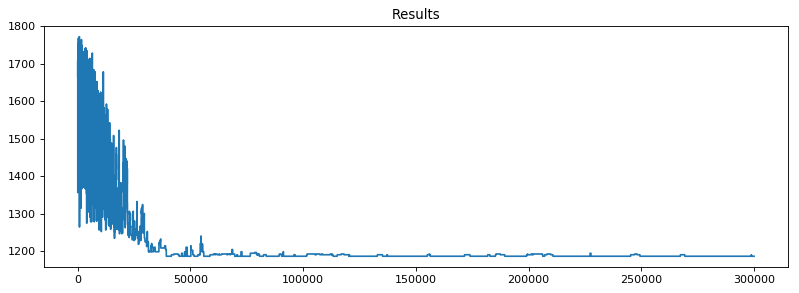

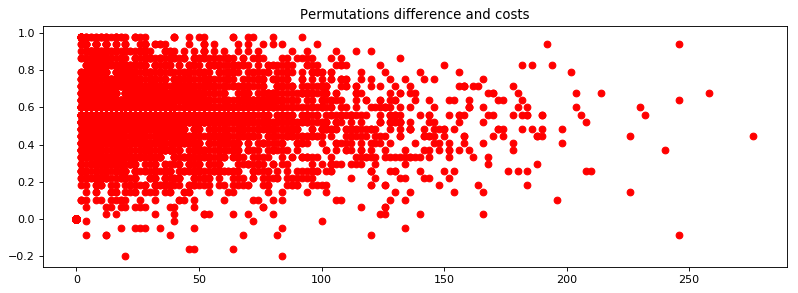

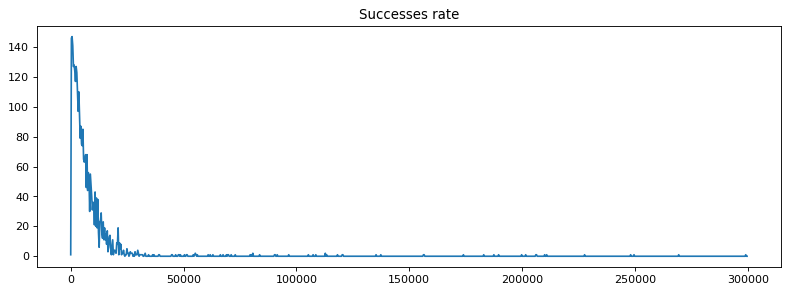

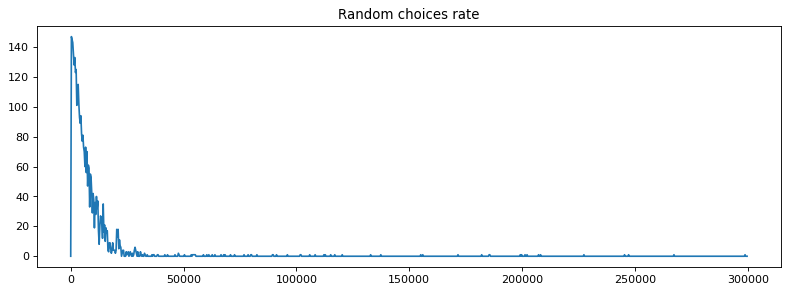

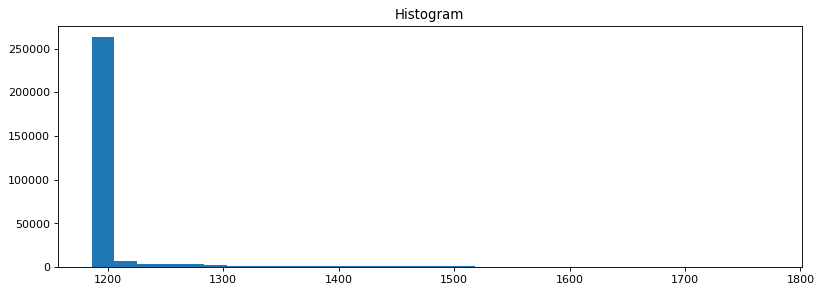

In [524]:
# Solution for problem size = 20

T = 300000
radius = 3
alpha = 0.95
S = 1

results = simulated_annealing(T, radius, alpha, nug_instance, flow, distance, S)
plot_results(nug_instance, T, **results)